<a href="https://colab.research.google.com/github/raduga256/Text-Classification-with-NLP-Tf-Idf-vs-Word2Vec-vs-BERT/blob/main/news_category_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## New Category Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT

There are different techniques to extract information from raw text data and use it to train a classification model. This tutorial compares the old school approach of Bag-of-Words (used with a simple machine learning algorithm), the popular Word Embedding model (used with a deep learning neural network), and the state of the art Language models (used with transfer learning from attention-based transformers) that have completely revolutionized the NLP landscape.

This article yourself first appearance paper of LIME in certain seminars "Why Should I Trust You?": Explaining the Predictions of Any Classifierare based on a slide that was announced.
https://irisu-inwl.github.io/reveal/lime

However, because this slide there is a feeling that was made for those who do not know the machine learning, it was summarized as anew article.

In [2]:
!pip -qq install lime

     |████████████████████████████████| 276kB 6.4MB/s 


In [3]:
 # Installing the Tranformers Library
 !pip -qq install transformers

     |████████████████████████████████| 2.0MB 5.1MB/s 
     |████████████████████████████████| 3.2MB 27.2MB/s 
     |████████████████████████████████| 870kB 38.8MB/s 


In [31]:
# First of all, I need to import the following libraries:

## for data
import json
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers


The dataset is contained into a json file, so I will first read it into a list of dictionaries with json and then transform it into a pandas Dataframe.

In [5]:
lst_dics = []
gdrive_loc = '/content/drive/My Drive/Colab Notebooks/'
with open(gdrive_loc+ "News_Category_Dataset_v2.json", mode='r', errors='ignore') as json_file :
  for dic in json_file:
    lst_dics.append(json.loads(dic))

## print the first one
lst_dics[0]

{'authors': 'Melissa Jeltsen',
 'category': 'CRIME',
 'date': '2018-05-26',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.'}

The original dataset contains over 30 categories, but for the purposes of this project, I will work with a subset of 3: Entertainment, Politics, and Tech.

In [25]:
## create datafrmae dtf
dtf = pd.DataFrame(lst_dics)

## filter categories
#dtf = dtf['category'].isin(['ENTERTAINMENT','POLITICS','TECH'])[["category","headline"]]

## rename columns
#dtf = dtf.rename(columns={"category":"y", "headline":"text"})

## print random rows
dtf.head(5)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [27]:
## filter categories
dtf = dtf[ dtf["category"].isin(['ENTERTAINMENT','POLITICS','TECH']) ][["category","headline"]]

## rename columns
#dtf = dtf.rename(columns={"category":"y", "headline":"text"})

## print random rows
dtf.head(5)

,category,headline
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...


In [29]:
## rename columns
dtf = dtf.rename(columns={"category":"y", "headline":"text"})
dtf.sample(5)

,y,text
59470,POLITICS,How 'The Good Wife' Got The Law Right
70469,ENTERTAINMENT,"Kim Kardashian Stayed In On New Year's Eve, Too"
64914,POLITICS,Ben Carson Formally Suspends Presidential Camp...
25451,ENTERTAINMENT,A 'Pirates Of The Caribbean' Set Features Arou...
17952,POLITICS,While Americans Focus On A Category 4 Hurrican...


In order to understand the composition of the dataset, I am going to look into the univariate distribution of the target by showing labels frequency with a bar plot.

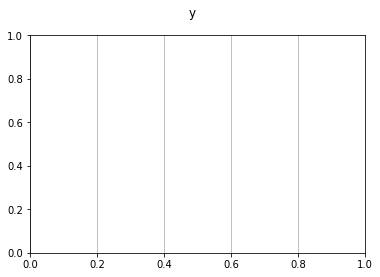

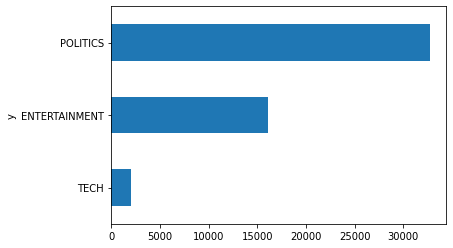

In [36]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)

dtf["y"].reset_index().groupby("y").count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax.grid(axis='x'))
                                                                         
plt.show()

The dataset is imbalanced: the proportion of Tech news is really small compared to the others, this will make for models to recognize Tech news rather tough.
Before explaining and building the models, I am going to give an example of preprocessing by cleaning text, removing stop words, and applying lemmatization. I will write a function and apply it to the whole data set.